In [251]:
import sys
sys.path.append('..')

In [252]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [253]:
import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
gpu_index = 2

print("Num GPUs Available: ", len(gpu_devices))
tf.config.set_visible_devices(gpu_devices[gpu_index], 'GPU')
tf.config.experimental.set_memory_growth(gpu_devices[gpu_index], True)

Num GPUs Available:  4


In [254]:
import os
swissprot_loc = '/ccs/home/pstjohn/project_work/swissprot/'

data = pd.read_parquet(os.path.join(swissprot_loc, 'parsed_swissprot.parquet'))
train = pd.read_csv(os.path.join(swissprot_loc, 'subcellular/train.csv.gz')).sample(frac=1.)
valid = pd.read_csv(os.path.join(swissprot_loc, 'subcellular/valid.csv.gz')).sample(frac=1.)
test  = pd.read_csv(os.path.join(swissprot_loc, 'subcellular/test.csv.gz')).sample(frac=1.)

num_targets = train.shape[1] - 1
compartments = list(train.columns[1:])

(324004, 19)

In [263]:
checkpoint_dir = '/ccs/home/pstjohn/member_work/uniparc_checkpoints/12_layer_localization_resampled.137403/'
tf.train.latest_checkpoint(checkpoint_dir)

from bert.model import create_albert_model

dimension = 768

model = create_albert_model(model_dimension=dimension,
                            transformer_dimension=dimension * 4,
                            num_attention_heads=dimension // 64,
                            num_transformer_layers=12,
                            dropout_rate=0.,
                            max_relative_position=64,
                            final_layernorm=False)

final_embedding = model.layers[-2].input
residue_predictions = tf.keras.layers.Dense(num_targets)(final_embedding)
protein_predictions = tf.keras.layers.GlobalMaxPooling1D()(residue_predictions)

localization_model = tf.keras.Model(model.inputs, protein_predictions)

localization_model.load_weights(tf.train.latest_checkpoint(checkpoint_dir)).expect_partial()
localization_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_5 (Embedding)      (None, None, 768)         18432     
_________________________________________________________________
transformer_60 (Transformer) (None, None, 768)         7096128   
_________________________________________________________________
transformer_61 (Transformer) (None, None, 768)         7096128   
_________________________________________________________________
transformer_62 (Transformer) (None, None, 768)         7096128   
_________________________________________________________________
transformer_63 (Transformer) (None, None, 768)         7096128   
_________________________________________________________________
transformer_64 (Transformer) (None, None, 768)         7096

In [264]:
from bert.dataset import encode
from functools import partial

valid_sequences = data.set_index('accession').reindex(valid.accession).sequence
valid_labels = valid.set_index('accession')

max_seq_len = 1500
batch_size = 16

valid_data = tf.data.Dataset.from_tensor_slices(valid_sequences.values).map(
    partial(encode, max_sequence_length=max_seq_len)).padded_batch(
    batch_size=batch_size, padded_shapes=[-1])

In [265]:
valid_predictions = tf.nn.sigmoid(localization_model.predict(valid_data, verbose=1))

625/625 [==============================] - 507s 810ms/step


In [266]:
from sklearn.metrics import auc, precision_recall_curve
def calc_pr_auc(i):
    precision, recall, thresholds = precision_recall_curve(valid_labels.iloc[:, i], valid_predictions.numpy()[:, i])
    return auc(recall, precision)

pr_auc = pd.DataFrame(pd.Series({col: calc_pr_auc(i) for i, col in enumerate(valid_labels.columns)}, name='auc'))

In [267]:
# pr_auc_no_pretrain

In [268]:
valid_predictions.shape

TensorShape([10000, 18])

In [269]:
# from sklearn.metrics import f1_score

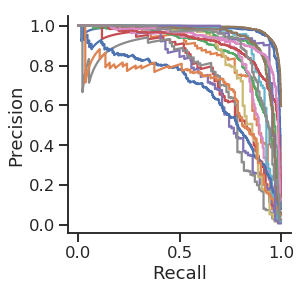

In [340]:
plt.figure(figsize=(4,4))
for i, col in enumerate(valid_labels.columns):
    precision, recall, thresholds = precision_recall_curve(valid_labels.iloc[:, i], valid_predictions.numpy()[:, i])
    plt.plot(recall, precision, label=col)
           
plt.xlabel('Recall')
plt.ylabel('Precision')
sns.despine()
plt.savefig('figs/pr_curves.svg')

In [271]:
from sklearn.metrics import auc, precision_recall_curve
def calc_pr_auc(i):
    precision, recall, thresholds = precision_recall_curve(valid_labels.iloc[:, i], valid_predictions.numpy()[:, i])
    return auc(recall, precision)

pr_auc = pd.DataFrame(pd.Series({col: calc_pr_auc(i) for i, col in enumerate(valid_labels.columns)}, name='auc'))

In [272]:
pr_auc = pd.DataFrame(pd.Series({col: calc_pr_auc(i) for i, col in enumerate(valid_labels.columns)}, name='auc'))

In [273]:
pr_auc['train_fraction'] = train.set_index('accession').sum(0) / len(train)

In [274]:
from itertools import cycle

In [275]:
pr_auc['no_pretrain'] = pr_auc_no_pretrain['auc']

In [276]:
for (i, row), marker in zip(pr_auc.iterrows(), cycle(('o', 'v', '<', 's', 'D', 'p'))):
    ax.plot(row.train_fraction, row.auc, marker=marker, label=row.name, ls='')

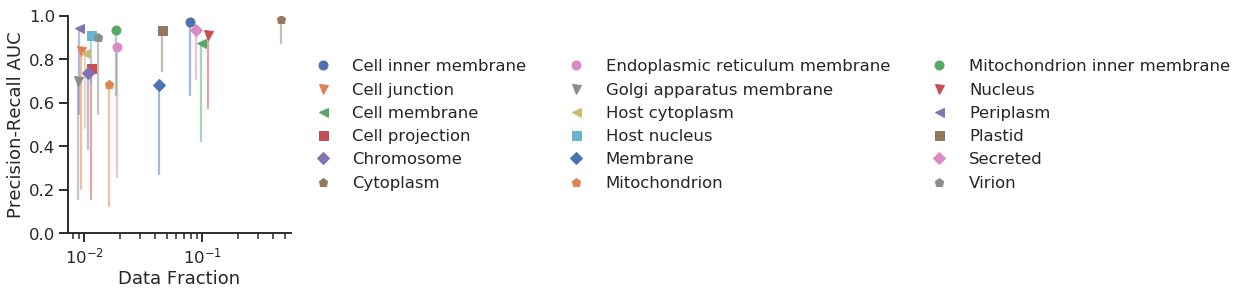

In [277]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

for (i, row), marker, color in zip(pr_auc.iterrows(), cycle(('o', 'v', '<', 's', 'D', 'p')), cycle(plt.rcParams['axes.prop_cycle'])):
    ax.plot(row.train_fraction, row.auc, marker=marker, label=row.name, ls='', color=color['color'])
    ax.plot([row.train_fraction, row.train_fraction], [row.no_pretrain, row.auc], color=color['color'], zorder=0, alpha=.5)
    

leg = ax.legend(loc='center left', ncol=3, bbox_to_anchor=(1., .5))
sns.despine()
#ax.set_xlim([0, .125])
ax.set_xscale('log')
ax.set_ylim([0, 1.])
ax.set_ylabel('Precision-Recall AUC')
ax.set_xlabel('Data Fraction')

plt.savefig('figs/with_pretrain.svg', bbox_extra_artists=(leg,))

In [278]:
residue_level_model = tf.keras.Model(localization_model.inputs, [localization_model.layers[-1].input])

In [279]:
compartments_to_plot = ['Cytoplasm', 'Secreted', 'Plastid', 'Cell inner membrane', 'Nucleus', 'Mitochondrion inner membrane']
compartment_sample = {c: valid_labels[valid_labels[c] == 1].sample(5, random_state=2).index for c in compartments_to_plot}

In [280]:
seqs = data.set_index('accession').reindex(np.concatenate([list(m) for m in compartment_sample.values()])).sequence

In [281]:
len(seqs)

30

In [282]:
list(tf.data.Dataset.from_tensor_slices(seqs.values).map(
        partial(encode, max_sequence_length=5000)).padded_batch(
        batch_size=15, padded_shapes=[-1]).take(1))

[<tf.Tensor: shape=(15, 752), dtype=int32, numpy=
 array([[21, 11,  9, ...,  0,  0,  0],
        [21, 11, 16, ...,  0,  0,  0],
        [21, 11, 10, ...,  0,  0,  0],
        ...,
        [21, 11, 10, ...,  0,  0,  0],
        [21, 11,  8, ..., 18,  6, 22],
        [21, 11, 10, ...,  0,  0,  0]], dtype=int32)>]

In [298]:
subset_ds = tf.data.Dataset.from_tensor_slices(seqs.values).map(
        partial(encode, max_sequence_length=5000)).padded_batch(
        batch_size=5, padded_shapes=[seqs.apply(len).max() + 2])

residue_predictions = tf.nn.sigmoid(residue_level_model.predict(subset_ds, verbose=1))

6/6 [==============================] - 42s 7s/step


In [284]:
residue_numpy = [residue[:ilen] for residue, ilen in zip(residue_predictions.numpy(), seqs.apply(len) + 2)]

In [303]:
subset_predictions = tf.nn.sigmoid(localization_model.predict(subset_ds, verbose=1))

6/6 [==============================] - 41s 7s/step


In [318]:
correct = valid_labels.reindex(np.concatenate(list(compartment_sample.values()))).astype(bool).values == (subset_predictions > .5)

array([ True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True, False,  True])

In [336]:
compartments_to_plot

['Cytoplasm',
 'Secreted',
 'Plastid',
 'Cell inner membrane',
 'Nucleus',
 'Mitochondrion inner membrane']

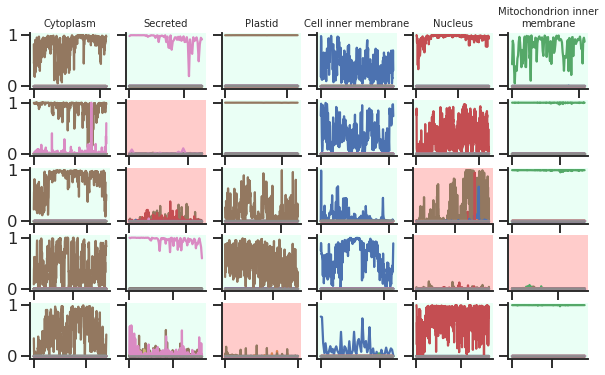

In [338]:
fig, axmatrix = plt.subplots(nrows=5, ncols=6, figsize=(10, 6), sharey=True)

for ax, resid_level_preds, is_correct in zip(axmatrix.T.flatten(), residue_numpy, np.all(correct, 1)):
    ax.plot(resid_level_preds)
    
    if is_correct:
        ax.set_facecolor('#eafff5')
    else:
        ax.set_facecolor('#ffcccb')
        
    sns.despine(ax=ax)
    plt.setp(ax.get_xticklabels(), visible=False)

for ax, title in zip(axmatrix[0, :], compartments_to_plot):
    if title == 'Mitochondrion inner membrane':
        title = 'Mitochondrion inner\nmembrane'
    ax.set_title(title, fontsize=10)
    
plt.savefig('figs/residue_level_predictions.svg')